In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
sys.path.insert(0, '../')
from scipy import misc
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras.layers import Reshape
from keras.layers import LocallyConnected2D
from keras.layers.convolutional import Conv2D
from keras.layers import *
from keras import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,TensorBoard, Callback
import matplotlib.pyplot as plt
%matplotlib nbagg
from keras.utils import np_utils
from keras import backend as K
import cv2
from common import util
from sklearn.model_selection import train_test_split
import random
import glob
import tensorflow as tf
K.set_image_dim_ordering('th')

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/dlutils/plot_image_batch_w_labels.py:16: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
   

In [2]:
np.max(misc.imread("/media/drc/DATA/chris_labelfusion/RGBDCNNTest/15predicted_depth.png"))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


249

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


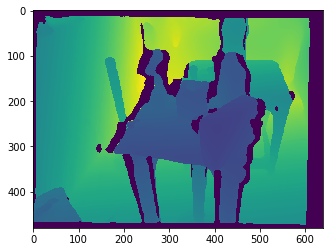

In [4]:
plt.figure()
plt.imshow(misc.imread("/media/drc/DATA/chris_labelfusion/RGBDCNNTest/15predicted_depth.png"))

<IPython.core.display.Javascript object>


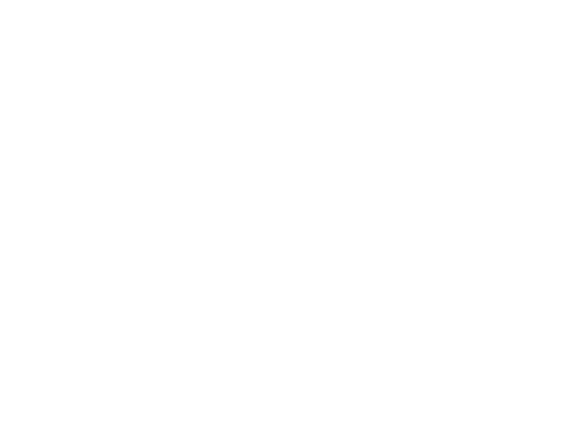

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.


In [258]:
path = "/media/drc/DATA/chris_labelfusion/CORL2017/logs_test/2017-06-16-47/resized_images/"
stuff = os.listdir(path)
plt.figure()
plt.imshow(misc.imread(path+stuff[np.random.randint(len(stuff))]))

In [48]:
import noise
from scipy.misc import toimage


In [49]:
def sigmoid(x):
    return 1. / (1 + np.exp(-10*x))

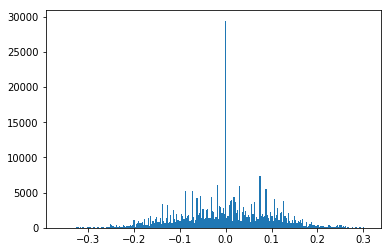

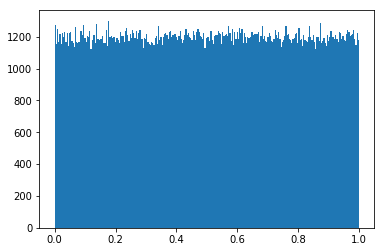

In [53]:

p = perlin_map(scale=8.0,octaves = 7,base= np.random.randint(1000),lacunarity = 6.0)
r = np.random.random((480,640))
plt.figure()
plt.hist(p.ravel(), bins=256)
plt.show()
plt.figure()
plt.hist(r.ravel(), bins=256)
plt.show()

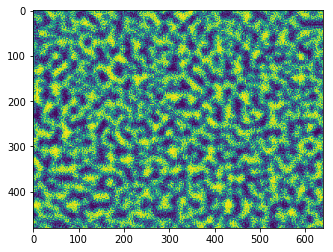

In [61]:
%matplotlib inline
plt.figure()
plt.imshow(img)

<IPython.core.display.Javascript object>


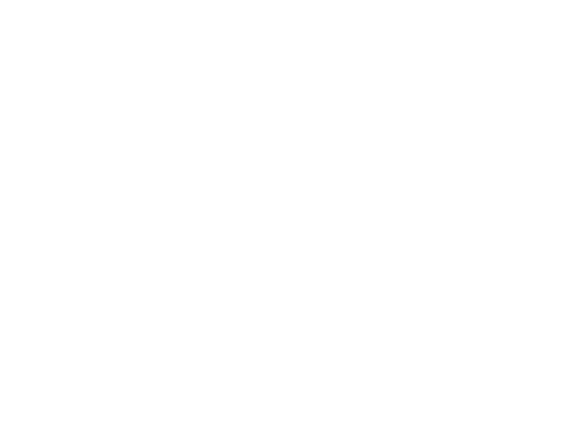

In [60]:
img = sigmoid(perlin_map(scale=20.0,octaves = 7,base= np.random.randint(1000),lacunarity = 6.0))
plt.figure()
plt.imshow(img)

<IPython.core.display.Javascript object>


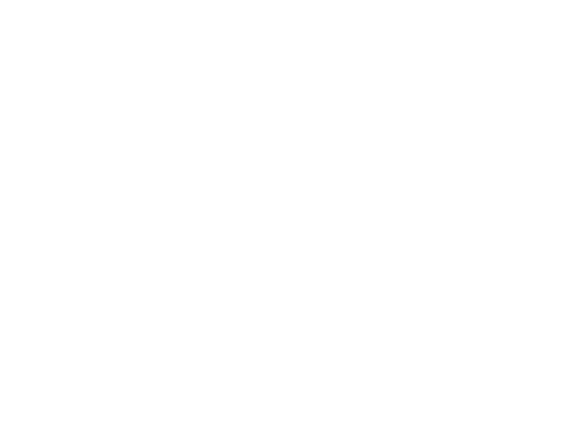

<IPython.core.display.Javascript object>


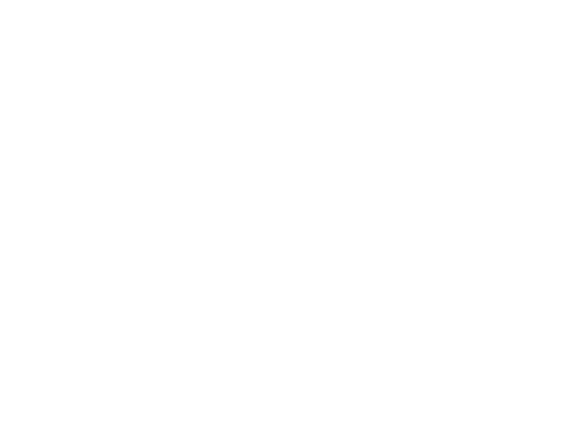

In [57]:
%matplotlib nbagg
plt.figure()
plt.imshow(sigmoid(perlin_map(scale=10.0,octaves = 7,base= np.random.randint(1000),lacunarity = 6.0)))
plt.figure()
plt.imshow(np.random.random((480,640)))

In [52]:
def perlin_map(shape = (480,640),scale = 100.0,octaves = 6,persistence = 0.5,lacunarity = 2.0,base = 0):
    img = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            img[i][j] = noise.pnoise2(i/scale, 
                                       j/scale, 
                                       octaves=octaves, 
                                       persistence=persistence, 
                                       lacunarity=lacunarity, 
                                       repeatx=shape[1], 
                                       repeaty=shape[0], 
                                       base=base)
    return img

In [3]:
def ratio_from_normal(img):
    return img[:,:,2]

def convert_rgb_normal(img):
    return (img/255.*2)-1.

In [4]:
def hot_vectorize(x,value = 0):
    zero_mask = x==value
    non_zero_mask = x!=value
    x[zero_mask] = 1
    x[non_zero_mask] = 0
    return x.astype(float)

def stack_frames(frames,img_height,img_width,channels):
    stack  = np.zeros((1,img_height,img_width,channels))
    index = 0
    for i in frames:
        num_chan = 1 if len(np.shape(i)) ==2 else np.shape(i)[2]
        stack[0,:,:,index:index+num_chan] = np.reshape(i,(img_height,img_width,num_chan))
        index += num_chan
    return stack

def grab_frame(files,i,path,func=None):
    img = misc.imread(path+files[i])
    if func:
        return func(img)
    return img

def grab_frame1(path,func=None):
    img = misc.imread(path)
    if func:
        return func(img)
    return img

def normalize(x):
    return x.astype(float)/3500.

def normalize_depth(x):
    return x.astype(float)/3000.

def convert_rgb_normal(img):
    return (img/255.*2)-1

def bounding_box(img,size = 100):
    h,w = np.shape(img)
    non_zeros = np.nonzero(img)
    x_min = np.min(non_zeros[0])
    x_max = np.max(non_zeros[0])
    y_min = np.min(non_zeros[1])
    y_max = np.max(non_zeros[1])
    out = (x_min,x_min+size,y_min,y_min+size) if size else (x_min,x_max,y_min,y_max)#minuce or plus coordinates
    if x_min< 0 or x_min+size > h or y_min<0 or y_min+size>w:
        return None
    return out

def crop(x,x1 = 100,x2 = 500,y1 = 50, y2 = 450):
    x = x[y1:y2,x1:x2]
    return x
def flip_vert(x,y):
    y= np.flip(y,axis=0)
    x= np.flip(x,axis=0)
    return x,y
def flip_hor(x,y):
    x= np.flip(x,axis=1)
    y= np.flip(y,axis=1)
    return x,y
def rotate(x,y):
    degrees = np.random.randint(360)
    centerx = tuple(np.array(x.shape[1::-1]) / 2)
    centery = tuple(np.array(y.shape[1::-1]) / 2)
    rotx = cv2.getRotationMatrix2D(centerx, degrees, 1.0)
    roty = cv2.getRotationMatrix2D(centery, degrees, 1.0)
    x = cv2.warpAffine(x, rotx, x.shape[1::-1], flags=cv2.INTER_LINEAR)
    y = cv2.warpAffine(y, roty, y.shape[1::-1], flags=cv2.INTER_LINEAR)
    return x,y
def augment(x,y,func = [],bias_to_real = .5):
    #x = crop(x)
   # y = crop(y)
    if np.random.rand()>bias_to_real:#bias to real images
        function = np.random.choice(func)
        x,y=function(x,y)
    return x,y


In [5]:
def cross_validate(samples,ways):
    samples = np.copy(samples)
    random.shuffle(samples)
    tests = np.array_split(samples,ways)
    return tests
def grab_test_train(tests,i):
    tests = np.copy(tests)
    test = list(tests).pop(i)
    train = np.concatenate(tests)
    return (train,test)
    

In [24]:
val = cross_validate(samples,10)
train, test = grab_test_train(val,0)

In [156]:
len(train), len(test)

(227737, 22774)

In [23]:
samples = gen_samples1("/media/drc/DATA/chris_labelfusion/RGBDCNN/")

In [25]:
train = generate_data_custom_both(train,func=[flip_hor,flip_vert,rotate],img_height=480,img_width=640)

In [7]:
def gen_samples1(directory,shuffle = True):
    samples = []
    dirs = os.listdir(directory)
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            gt_normal = sorted(glob.glob(path+"*_normal_*"))
            gt_depth = sorted(glob.glob(path+"*_depth_*"))
            depth = sorted(glob.glob(path+"*_depth.png*"))
            samples.extend(zip(gt_depth,gt_normal,depth))
    if shuffle:
        random.shuffle(samples)
    return samples  

In [8]:
def gen_samples(directory,shuffle = True):
    samples = []
    dirs = os.listdir(directory)
    for i in dirs:
        path = os.path.join(directory, i)+"/"
        if os.access(path, os.R_OK):
            gt_depth = sorted(glob.glob(path+"*_truth.png"))
            depth = sorted(glob.glob(path+"*_depth.png"))
            samples.extend(zip(gt_depth,depth))
    if shuffle:
        random.shuffle(samples)
    return samples                

In [20]:
def generate_data_custom_both(samples,img_height=480,img_width=640,batch_size=4,func=[]):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,2))#2
        stack2 = np.zeros((batch_size,img_height,img_width,1))
        j=0
        while j<batch_size:
            try: 
                rgb = samples[i][0]
                normal = samples[i][1]
                depth = samples[i][2]
                normal_img = grab_frame1(normal,convert_rgb_normal)[:,:,2]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                
                #rgb_img,depth_img = augment(rgb_img,depth_img,func,bias_to_real = .5)
                stack1[j,:,:,0] = rgb_img
                stack1[j,:,:,1] = normal_img
                stack2[j,:,:,0] = depth_img
                j+=1
                i= (i+1)%len(samples)
            except Exception:
                i=(i+1)%len(samples)
        yield (stack1,stack2)

In [10]:
def generate_data_custom_depth(samples,img_height=480,img_width=640,batch_size=4,func=[]):
    i = 0
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,1))
        stack2 = np.zeros((batch_size,img_height,img_width,1))
        j=0
        while j<batch_size:
            try: 
                rgb = samples[i][0]
                depth = samples[i][1]
                rgb_img = grab_frame1(rgb,normalize)
                depth_img = grab_frame1(depth,hot_vectorize)
                rgb_img,depth_img = augment(rgb_img,depth_img,func,bias_to_real = .5)
                stack1[j] = np.reshape(rgb_img,(img_height,img_width,1))
                stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
                j+=1
                i= (i+1)%len(samples)
            except Exception:
                i=(i+1)%len(samples)
        yield (stack1,stack2)

In [12]:
def generate_data_custom1(depth_as_mask=True,img_height=480,img_width=640,batch_size=4,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"
    depth_path = path+"depth/"

    rgb = np.sort(os.listdir(rgb_path))
    depth = np.sort(os.listdir(depth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            depth = np.sort(filter(lambda x: filter_files in x, depth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,3))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(rgb)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
          
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            stack = stack_frames([rgb_img],img_height,img_width,3)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [13]:
def generate_data_custom3(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,7))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            gtdepth_img[gtdepth_img==0]=1.

            stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,7)
            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [14]:
def generate_data_custom(depth_as_mask=True,img_height=480,img_width=640,batch_size=8,channels =1,path="/media/drc/DATA/CNN/",dir_name = "test/",filter_files = None,func=None):

    rgb_path = path+"rgb/"+"rgb/"
    depth_path = path+"depth/"+ "depth/"
    gtdepth_path = path+"gtdepth/" + "gtdepth/"
    normal_path = path+"normal/" + "normal/"

    rgb = np.sort(os.listdir(rgb_path))
    normal = np.sort(os.listdir(normal_path))
    depth = np.sort(os.listdir(depth_path))
    gtdepth = np.sort(os.listdir(gtdepth_path))

    if filter_files:
            rgb = np.sort(filter(lambda x: filter_files in x, rgb))
            normal = np.sort(filter(lambda x: filter_files in x, normal))
            depth = np.sort(filter(lambda x: filter_files in x, depth))
            gtdepth = np.sort(filter(lambda x: filter_files in x, gtdepth))

    i = -1
    while True:
        stack1 = np.zeros((batch_size,img_height,img_width,channels))
        stack2 = np.zeros((batch_size,img_height,img_width,1))

        for j in range(batch_size):
            i= (i+1)%len(depth)
            rgb_img = grab_frame(rgb,i,rgb_path,func)
            normal_img = grab_frame(normal,i,normal_path,normalize)
            gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
            depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
            a = bounding_box(gtdepth_img,img_height)
            while not a:
                i= (i+1)%len(depth)
                rgb_img = grab_frame(rgb,i,rgb_path,func)
                normal_img = grab_frame(normal,i,normal_path,normalize)
                gtdepth_img = grab_frame(gtdepth,i,gtdepth_path,normalize_depth)
                depth_img = grab_frame(depth,i,depth_path,hot_vectorize)
                a = bounding_box(gtdepth_img,img_height)

            x1,x2,y1,y2 = a
            depth_img = depth_img[x1:x2,y1:y2] 
            gtdepth_img = gtdepth_img[x1:x2,y1:y2]
            normal_img = normal_img[x1:x2,y1:y2]
            gtdepth_img[gtdepth_img==0]=1.

            #stack = stack_frames([gtdepth_img,normal_img,rgb_img],img_height,img_width,4)
            stack = stack_frames([gtdepth_img],img_height,img_width,channels)

            stack1[j] = stack
            stack2[j] = np.reshape(depth_img,(img_height,img_width,1))
        yield (stack1,stack2)

In [68]:
gen  = generate_data_custom( func=normalize)

In [17]:
img_height=400
img_width=400

In [44]:
np.shape(train.next()[1])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(4, 480, 640, 1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


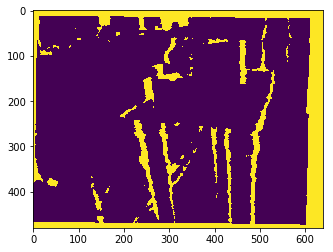

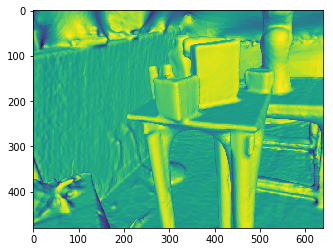

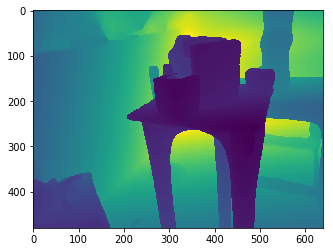

In [28]:
%matplotlib inline
now = train.next()
plt.figure()
plt.imshow(now[1][0,:,:,0])
plt.figure()
plt.imshow(now[0][0][:,:,1])
plt.figure()
plt.imshow(now[0][0][:,:,0])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


<IPython.core.display.Javascript object>


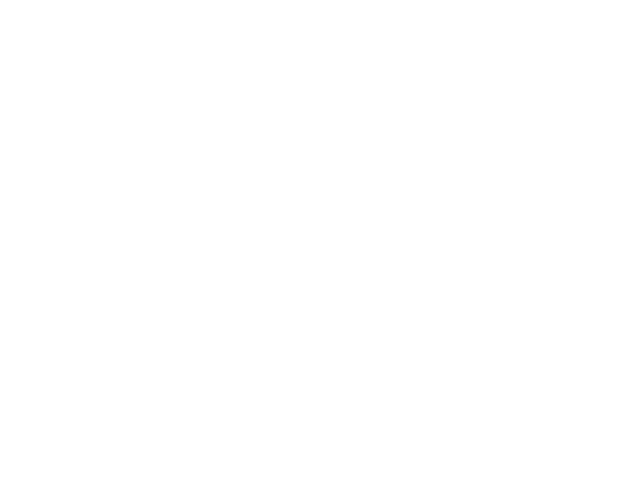

<IPython.core.display.Javascript object>


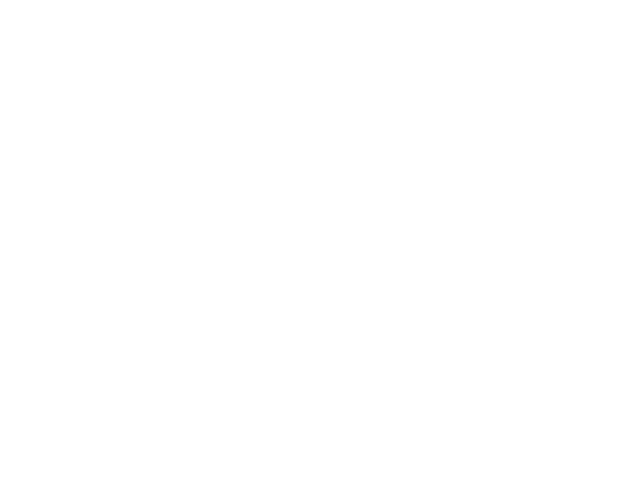

<IPython.core.display.Javascript object>


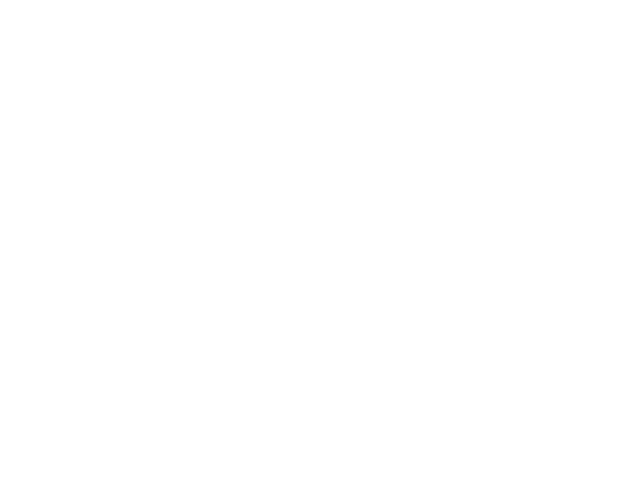

<IPython.core.display.Javascript object>


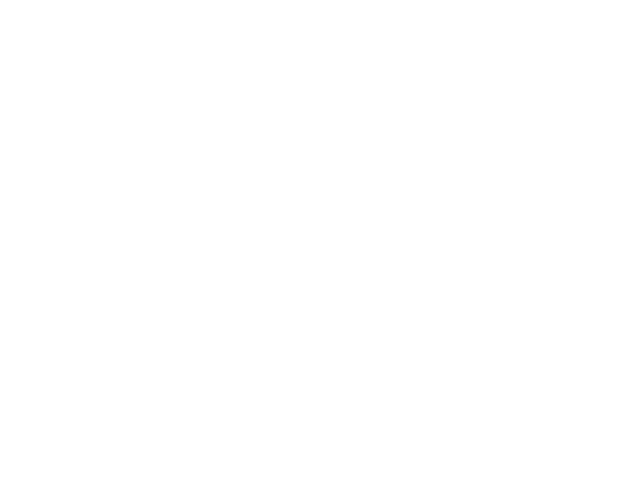

In [58]:
%matplotlib nbagg
now = gen.next()
plt.figure()
plt.imshow(np.reshape(now[1][0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,0],(480,640)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,1:4],(480,640,3)))
plt.figure()
plt.imshow(np.reshape(now[0][0,:,:,4:],(480,640,3)))

In [12]:
img_height = 480 #check with old params
img_width = 640
inputs = Input((img_height, img_width,1))

In [21]:
from keras import models
from keras.layers.core import Activation, Reshape, Permute
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
import json

img_w = img_width
img_h = img_height
n_labels = 2

kernel = 3

encoding_layers = [
    Convolution2D(16, kernel, border_mode='same', input_shape=( img_h, img_w,1),data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),

    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(data_format='channels_last'),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)

decoding_layers = [
    UpSampling2D(data_format='channels_last'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(128, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(64, kernel,  border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(32, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(data_format='channels_last'),
    Convolution2D(16, kernel, border_mode='same',data_format='channels_last'),
    BatchNormalization(),
    Activation('relu'),
    Convolution2D(1, 1, border_mode='valid',data_format='channels_last'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)


#autoencoder.add(Reshape((n_labels, img_h * img_w)))
#autoencoder.add(Permute((2, 1)))
autoencoder.add(Activation('sigmoid'))

autoencoder.summary()
autoencoder.compile(optimizer = optimizers.Adam(lr = 1e-4), loss =  binary_crossentropy, metrics = ['accuracy'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, 3, padding="same", data_format="channels_last", input_shape=(480, 640,...)`
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, 3, padding="same", data_format="channels_last")`
/usr/local/lib/python2.7/dist-packages/ipyker

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 480, 640, 16)      160       
_________________________________________________________________
batch_normalization_79 (Batc (None, 480, 640, 16)      64        
_________________________________________________________________
activation_79 (Activation)   (None, 480, 640, 16)      0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 480, 640, 16)      2320      
_________________________________________________________________
batch_normalization_80 (Batc (None, 480, 640, 16)      64        
_________________________________________________________________
activation_80 (Activation)   (None, 480, 640, 16)      0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 240, 320, 16)      0         
__________

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


<IPython.core.display.Javascript object>


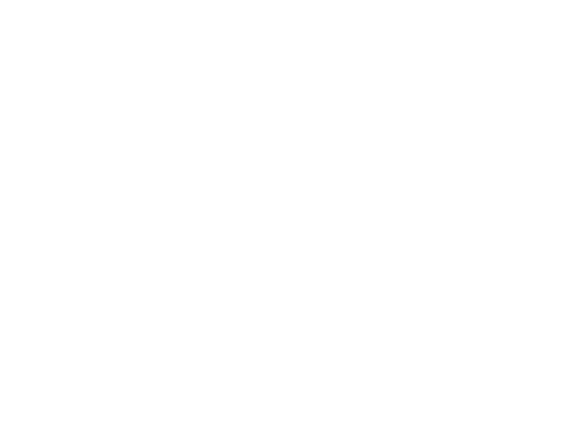

In [233]:
import struct
cpp_int_size = 4
cpp_ushort_size = 2
i = np.random.randint(1000)
with open("/media/drc/DATA/linemod/driller/data/depth"+str(i)+".dpt", 'rb') as f:
    rows_b = f.read(cpp_int_size) # I assume that the C++ int in question has 4 bits ... trial and error
    cols_b = f.read(cpp_int_size)

    R = struct.unpack('<i', rows_b)[0] # small endian
    C = struct.unpack('<i', cols_b)[0]
    depth_image_str = f.read(R * C * cpp_ushort_size)
depth_img = np.fromstring(depth_image_str, dtype=np.uint16).reshape([R, C])
plt.figure()
plt.imshow(depth_img)

In [234]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

img = depth_img
dst_TELEA = cv2.inpaint(img,(img==0).astype(np.uint8),3,cv2.INPAINT_TELEA)
dst_NS = cv2.inpaint(img,(img==0).astype(np.uint8),3,cv2.INPAINT_NS)

# plt.subplot(221), plt.imshow(img)
# plt.title('degraded image')
# plt.subplot(222), plt.imshow((img==0).astype(np.uint8), 'gray')
# plt.title('mask image')
# plt.subplot(223), plt.imshow(dst_TELEA)
# plt.title('TELEA')
# plt.subplot(224), plt.imshow(dst_NS)
# plt.title('NS')

# plt.tight_layout()
# plt.show()

<IPython.core.display.Javascript object>


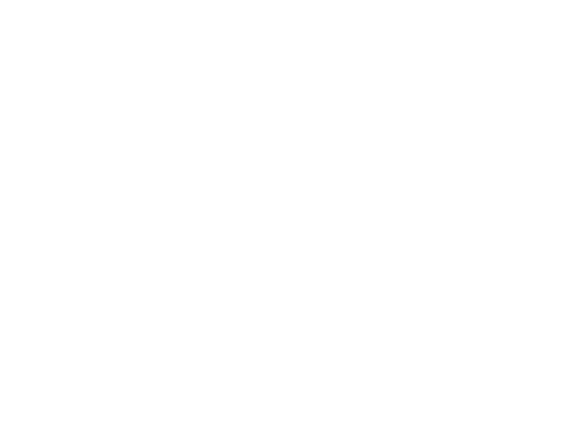

In [235]:
batch = np.zeros((1,480,640,1))
batch[0,:,:,0] = dst_TELEA/3500.
x = model.predict_on_batch(batch)
plt.figure()
plt.imshow(x[0,:,:,0])

In [237]:
apply_mask(x,dst_TELEA,.5)

<IPython.core.display.Javascript object>


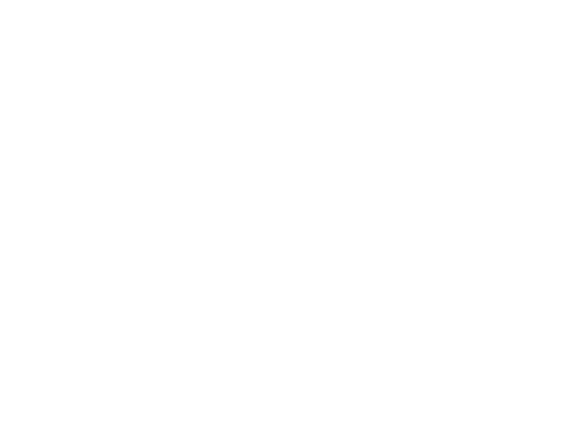

<IPython.core.display.Javascript object>


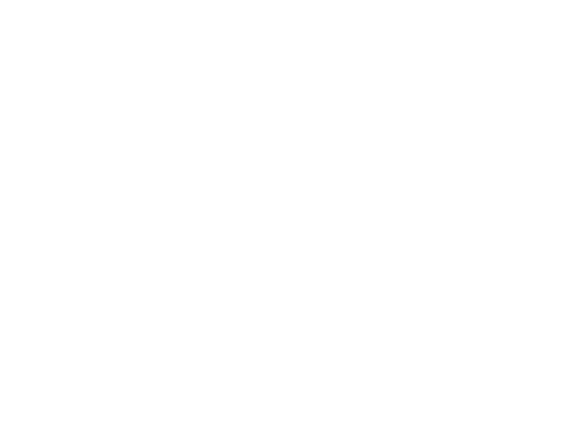

In [259]:
plt.figure()
plt.imshow(dst_TELEA)
plt.figure()
plt.imshow(depth_img)

In [193]:
def apply_mask(mask,depth,threshold):
    epsilon = .05
    h,w = np.shape(depth)
    mask = np.reshape(mask,(h,w))

    depth[mask>threshold]=0
    #img = np.random.random((480,640))
    img = sigmoid(perlin_map(scale=20.0,octaves = 7,base= np.random.randint(1000),lacunarity = 6.0))
    stochastic_mask = mask>=img
    #stochastic_mask = np.logical_and(np.logical_and((mask<=threshold), mask>epsilon), img<threshold)
    depth[stochastic_mask] = 0

In [11]:
import scipy

In [ ]:
scipy.misc.t

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


<IPython.core.display.Javascript object>


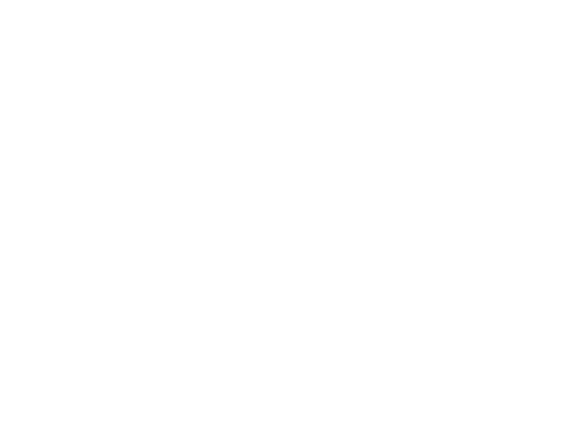

In [28]:
%matplotlib nbagg
plt.imshow(misc.imread("/media/drc/DATA/chris_labelfusion/RGBDCNNTest/0gtdepth.png"))

In [ ]:
def convert_to dropout(imgs,autoencoder,out="./"):
    

In [23]:
autoencoder.load_weights("../models/net_segnet_aug.hdf5")

In [15]:
def binary_crossentropy(y_true, y_pred):
    print np.shape(y_true),np.shape(y_pred)
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [16]:
def weighted_pixelwise_crossentropy(class_weights):
    
    def loss(y_true, y_pred):
        epsilon = tf.convert_to_tensor(.01, y_pred.dtype.base_dtype)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        return - tf.reduce_sum(tf.multiply(y_true * tf.log(y_pred), tf.convert_to_tensor(class_weights.values())))

    return loss

In [29]:
_EPSILON = 10e-8
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
def crop1(x,x1 = 100,x2 = 500,y1 = 50, y2 = 450):
    x = x[:,y1:y2,x1:x2,:]
    return x

In [32]:
def binary_crossentropy(target, output, from_logits=False):
    """Binary crossentropy between an output tensor and a target tensor.
      Arguments:
          target: A tensor with the same shape as `output`.
          output: A tensor.
          from_logits: Whether `output` is expected to be a logits tensor.
              By default, we consider that `output`
              encodes a probability distribution.
      Returns:
          A tensor.
      """
    #target  = crop1(target)
   # output = crop1(output)
    #print np.shape(target), np.shape(output)

      # Note: nn.softmax_cross_entropy_with_logits
      # expects logits, Keras expects probabilities.
    if not from_logits:
        # transform back to logits
        epsilon_ =  tf.convert_to_tensor(_EPSILON, output.dtype.base_dtype)
        output = clip_ops.clip_by_value(output, epsilon_, 1 - epsilon_)
        output = math_ops.log(output / (1 - output))
    return nn.weighted_cross_entropy_with_logits(target, output, .15, name=None)


In [33]:
class_weight = {0 : .85,
    1: .15}

In [31]:
batch_size =4

In [160]:
model_checkpoint = ModelCheckpoint('net_segnet_aug_custom metric.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs1', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
autoencoder.fit_generator(train, nb_epoch=10000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=10000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/10000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.0248 - acc: 0.9606
Epoch 00001: loss improved from inf to 0.02474, saving model to net_segnet_aug_custom metric.hdf5
100/100 [==============================] - 46s 462ms/step - loss: 0.0247 - acc: 0.9607
Epoch 2/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0252 - acc: 0.9597
Epoch 00002: loss did not improve
100/100 [==============================] - 45s 449ms/step - loss: 0.0251 - acc: 0.9599
Epoch 3/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9588
Epoch 00003: loss did not improve
100/100 [==============================] - 47s 466ms/step - loss: 0.0253 - acc: 0.9589
Epoch 4/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0256 - acc: 0.9581
Epoch 00004: loss did not improve
100/100 [==============================] - 46s 458ms/step - loss: 0.0256 - acc: 0.9580
Epoch 5/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0254 - acc: 0.9

Epoch 38/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9598
Epoch 00038: loss did not improve
100/100 [==============================] - 49s 489ms/step - loss: 0.0244 - acc: 0.9598
Epoch 39/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0244 - acc: 0.9593
Epoch 00039: loss did not improve
100/100 [==============================] - 49s 493ms/step - loss: 0.0243 - acc: 0.9594
Epoch 40/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0241 - acc: 0.9596
Epoch 00040: loss did not improve
100/100 [==============================] - 55s 546ms/step - loss: 0.0240 - acc: 0.9596
Epoch 41/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0251 - acc: 0.9580
Epoch 00041: loss did not improve
100/100 [==============================] - 53s 531ms/step - loss: 0.0251 - acc: 0.9581
Epoch 42/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9613
Epoch 00042: loss did not improve
100/100

Epoch 112/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0236 - acc: 0.9592
Epoch 00112: loss did not improve
100/100 [==============================] - 66s 659ms/step - loss: 0.0237 - acc: 0.9591
Epoch 113/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0230 - acc: 0.9607
Epoch 00113: loss did not improve
100/100 [==============================] - 68s 678ms/step - loss: 0.0229 - acc: 0.9608
Epoch 114/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9609
Epoch 00114: loss did not improve
100/100 [==============================] - 66s 664ms/step - loss: 0.0229 - acc: 0.9610
Epoch 115/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9597
Epoch 00115: loss did not improve
100/100 [==============================] - 68s 678ms/step - loss: 0.0234 - acc: 0.9596
Epoch 116/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9605
Epoch 00116: loss did not improve
10

Epoch 187/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9591
Epoch 00187: loss did not improve
100/100 [==============================] - 71s 710ms/step - loss: 0.0235 - acc: 0.9590
Epoch 188/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9604
Epoch 00188: loss did not improve
100/100 [==============================] - 70s 700ms/step - loss: 0.0228 - acc: 0.9604
Epoch 189/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9603
Epoch 00189: loss did not improve
100/100 [==============================] - 70s 704ms/step - loss: 0.0229 - acc: 0.9603
Epoch 190/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9597
Epoch 00190: loss did not improve
100/100 [==============================] - 71s 708ms/step - loss: 0.0232 - acc: 0.9598
Epoch 191/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9600
Epoch 00191: loss did not improve
10

 99/100 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9613
Epoch 00261: loss did not improve
100/100 [==============================] - 73s 729ms/step - loss: 0.0217 - acc: 0.9614
Epoch 262/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9613
Epoch 00262: loss did not improve
100/100 [==============================] - 73s 728ms/step - loss: 0.0217 - acc: 0.9612
Epoch 263/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9615
Epoch 00263: loss did not improve
100/100 [==============================] - 73s 732ms/step - loss: 0.0216 - acc: 0.9616
Epoch 264/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9596
Epoch 00264: loss did not improve
100/100 [==============================] - 71s 710ms/step - loss: 0.0231 - acc: 0.9597
Epoch 265/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9611
Epoch 00265: loss did not improve
100/100 [=========

Epoch 299/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0234 - acc: 0.9587
Epoch 00299: loss did not improve
100/100 [==============================] - 74s 738ms/step - loss: 0.0234 - acc: 0.9587
Epoch 300/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0229 - acc: 0.9599
Epoch 00300: loss did not improve
100/100 [==============================] - 74s 736ms/step - loss: 0.0228 - acc: 0.9600
Epoch 301/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9618
Epoch 00301: loss did not improve
100/100 [==============================] - 72s 722ms/step - loss: 0.0216 - acc: 0.9618
Epoch 302/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9625
Epoch 00302: loss did not improve
100/100 [==============================] - 74s 742ms/step - loss: 0.0213 - acc: 0.9626
Epoch 303/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9614
Epoch 00303: loss did not improve
10

Epoch 337/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9617
Epoch 00337: loss did not improve
100/100 [==============================] - 75s 751ms/step - loss: 0.0217 - acc: 0.9618
Epoch 338/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9617
Epoch 00338: loss did not improve
100/100 [==============================] - 73s 729ms/step - loss: 0.0217 - acc: 0.9617
Epoch 339/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9609
Epoch 00339: loss did not improve
100/100 [==============================] - 75s 745ms/step - loss: 0.0219 - acc: 0.9609
Epoch 340/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9595
Epoch 00340: loss did not improve
100/100 [==============================] - 73s 734ms/step - loss: 0.0227 - acc: 0.9596
Epoch 341/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9609
Epoch 00341: loss did not improve
10

Epoch 375/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0222 - acc: 0.9607
Epoch 00375: loss did not improve
100/100 [==============================] - 74s 737ms/step - loss: 0.0222 - acc: 0.9608
Epoch 376/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0228 - acc: 0.9595
Epoch 00376: loss did not improve
100/100 [==============================] - 76s 759ms/step - loss: 0.0227 - acc: 0.9596
Epoch 377/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9609
Epoch 00377: loss did not improve
100/100 [==============================] - 73s 727ms/step - loss: 0.0219 - acc: 0.9610
Epoch 378/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9608
Epoch 00378: loss did not improve
100/100 [==============================] - 75s 752ms/step - loss: 0.0220 - acc: 0.9608
Epoch 379/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.9616
Epoch 00379: loss did not improve
10

Epoch 413/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0219 - acc: 0.9614
Epoch 00413: loss did not improve
100/100 [==============================] - 78s 776ms/step - loss: 0.0219 - acc: 0.9614
Epoch 414/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9623
Epoch 00414: loss did not improve
100/100 [==============================] - 76s 759ms/step - loss: 0.0212 - acc: 0.9624
Epoch 415/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0225 - acc: 0.9600
Epoch 00415: loss did not improve
100/100 [==============================] - 75s 754ms/step - loss: 0.0225 - acc: 0.9600
Epoch 416/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0226 - acc: 0.9598
Epoch 00416: loss did not improve
100/100 [==============================] - 76s 764ms/step - loss: 0.0225 - acc: 0.9598
Epoch 417/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9609
Epoch 00417: loss did not improve
10

Epoch 488/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9613
Epoch 00488: loss did not improve
100/100 [==============================] - 74s 742ms/step - loss: 0.0217 - acc: 0.9614
Epoch 489/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9616
Epoch 00489: loss did not improve
100/100 [==============================] - 76s 760ms/step - loss: 0.0216 - acc: 0.9616
Epoch 490/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9620
Epoch 00490: loss did not improve
100/100 [==============================] - 76s 757ms/step - loss: 0.0212 - acc: 0.9620
Epoch 491/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9612
Epoch 00491: loss did not improve
100/100 [==============================] - 73s 734ms/step - loss: 0.0221 - acc: 0.9612
Epoch 492/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9616
Epoch 00492: loss did not improve
10

Epoch 526/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9620
Epoch 00526: loss did not improve
100/100 [==============================] - 78s 780ms/step - loss: 0.0212 - acc: 0.9620
Epoch 527/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9612
Epoch 00527: loss did not improve
100/100 [==============================] - 75s 754ms/step - loss: 0.0215 - acc: 0.9613
Epoch 528/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9630
Epoch 00528: loss did not improve
100/100 [==============================] - 76s 755ms/step - loss: 0.0207 - acc: 0.9628
Epoch 529/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9627
Epoch 00529: loss did not improve
100/100 [==============================] - 76s 761ms/step - loss: 0.0208 - acc: 0.9626
Epoch 530/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0215 - acc: 0.9615
Epoch 00530: loss did not improve
10

Epoch 564/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9633
Epoch 00564: loss did not improve
100/100 [==============================] - 78s 775ms/step - loss: 0.0206 - acc: 0.9633
Epoch 565/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0227 - acc: 0.9593
Epoch 00565: loss did not improve
100/100 [==============================] - 76s 757ms/step - loss: 0.0226 - acc: 0.9594
Epoch 566/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9641
Epoch 00566: loss did not improve
100/100 [==============================] - 77s 773ms/step - loss: 0.0202 - acc: 0.9638
Epoch 567/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9607
Epoch 00567: loss did not improve
100/100 [==============================] - 78s 778ms/step - loss: 0.0220 - acc: 0.9607
Epoch 568/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0214 - acc: 0.9615
Epoch 00568: loss did not improve
10

Epoch 601/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9630
Epoch 00601: loss did not improve
100/100 [==============================] - 48s 484ms/step - loss: 0.0207 - acc: 0.9629
Epoch 602/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9630
Epoch 00602: loss did not improve
100/100 [==============================] - 50s 495ms/step - loss: 0.0207 - acc: 0.9629
Epoch 603/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9652
Epoch 00603: loss improved from 0.01955 to 0.01940, saving model to net_segnet_aug_custom metric.hdf5
100/100 [==============================] - 49s 486ms/step - loss: 0.0194 - acc: 0.9652
Epoch 604/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0213 - acc: 0.9618
Epoch 00604: loss did not improve
100/100 [==============================] - 49s 487ms/step - loss: 0.0212 - acc: 0.9619
Epoch 605/10000
 99/100 [============================>.] - ETA: 

Epoch 676/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9619
Epoch 00676: loss did not improve
100/100 [==============================] - 67s 674ms/step - loss: 0.0212 - acc: 0.9619
Epoch 677/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9624
Epoch 00677: loss did not improve
100/100 [==============================] - 66s 657ms/step - loss: 0.0208 - acc: 0.9625
Epoch 678/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9636
Epoch 00678: loss did not improve
100/100 [==============================] - 65s 652ms/step - loss: 0.0200 - acc: 0.9636
Epoch 679/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9640
Epoch 00679: loss did not improve
100/100 [==============================] - 68s 684ms/step - loss: 0.0200 - acc: 0.9640
Epoch 680/10000
 99/100 [============================>.] - ETA: 0s - loss: 0.0206 - acc: 0.9628
Epoch 00680: loss did not improve
10

KeyboardInterrupt: 

In [34]:
inputs = Input((480,640,2))
#crop = Cropping2D(cropping=((0, 0), (0, 0)), data_format=None)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(inputs)
conv1 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv1)

conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool1)
conv2 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv2)

conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool2)
conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2),data_format='channels_last')(conv3)

conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(pool3)
conv5 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv5)
drop5 = Dropout(0.5)(conv5)

up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv5))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge7)
conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv7)

up8 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge8)
conv8 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv8)

up9 = Conv2D(4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(UpSampling2D(size = (2,2),data_format='channels_last')(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(merge9)
conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',data_format='channels_last')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid',data_format='channels_last')(conv9)

model = Model(input = inputs, output = conv10)
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss =  binary_crossentropy, metrics = ['accuracy'])
print model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 640, 4)  76          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 480, 640, 4)  148         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 240, 320, 4)  0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Update

In [35]:
model.load_weights("../models/net_depth_seg_v1.hdf5")

ValueError: Dimension 0 in both shapes must be equal, but are 3 and 4 for 'Assign' (op: 'Assign') with input shapes: [3,3,2,4], [4,1,3,3].

In [113]:
def network(input_image_tensor):
    def resnet_block_1(input_features, nb_features=16, nb_kernel_rows=3, nb_kernel_cols=3):

        y = Conv2D(nb_features, nb_kernel_cols, padding='same',data_format='channels_last')(input_features)
        y = Activation('relu')(y)
        y = Conv2D(nb_features, nb_kernel_rows, padding='same',data_format='channels_last')(y)

        y = add([input_features, y])
        return Activation('relu')(y)

    x = Conv2D(4, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)
    x = Conv2D(16, 3, padding='same', activation='relu',data_format='channels_last')(input_image_tensor)

    for _ in range(4):
        x = resnet_block_1(x)
        
    x = Conv2D(1, 1, padding='same', activation='sigmoid',data_format='channels_last')(x)

    
    model = Model(input = inputs, output = x)
    print model.summary()
    model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [78]:
model = network(inputs)

NameError: name 'network' is not defined

In [24]:
batch_size = 8

In [23]:
from keras import backend as K
class Image_Saver(Callback):
    def on_train_begin(self,logs={}):
        self.var_y_pred = tf.placeholder(tf.float32, [FLAGS.batch_size, 480,640,1])
        #self.var_y_pred = tf.Variable(0., validate_shape=False)

    def on_batch_end(self, batch, logs={}):
            #callback = TensorBoard(log_path)
            #callback.set_model(model)
            
            print type(K.eval(self.model.outputs[0]))
            x=self.model.predict_on_batch(batch)
            writer = tf.summary.FileWriter('./logs1')
            writer.add_summary(tf.summary.image('input', x[0]))
save = Image_Saver()

In [78]:
batch_size

4

In [36]:
model_checkpoint = ModelCheckpoint('small_res_depth_normal_batch4.hdf5', monitor='loss',verbose=1, save_best_only=True)
check2 = TensorBoard(log_dir='logs_new', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
print('Fitting model...')
model.fit_generator(train, nb_epoch=1000,steps_per_epoch=100, verbose=1, shuffle=True, callbacks=[model_checkpoint,check2])

Fitting model...


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., shuffle=True, verbose=1, steps_per_epoch=100, epochs=1000, callbacks=[<keras.ca...)`
  after removing the cwd from sys.path.


Epoch 1/1000


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


 99/100 [============================>.] - ETA: 0s - loss: 0.4956 - acc: 0.6434
Epoch 00001: loss improved from inf to 0.49211, saving model to small_res_depth_normal_batch4.hdf5
100/100 [==============================] - 47s 467ms/step - loss: 0.4921 - acc: 0.6452
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.1091 - acc: 0.8285
Epoch 00002: loss improved from 0.49211 to 0.10901, saving model to small_res_depth_normal_batch4.hdf5
100/100 [==============================] - 44s 442ms/step - loss: 0.1090 - acc: 0.8285
Epoch 3/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0782 - acc: 0.8421
Epoch 00003: loss improved from 0.10901 to 0.07812, saving model to small_res_depth_normal_batch4.hdf5
100/100 [==============================] - 47s 471ms/step - loss: 0.0781 - acc: 0.8421
Epoch 4/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0682 - acc: 0.8447
Epoch 00004: loss improved from 0.07812 to 0.06819, saving model to small_r

 99/100 [============================>.] - ETA: 0s - loss: 0.0491 - acc: 0.9222
Epoch 00034: loss did not improve
100/100 [==============================] - 49s 489ms/step - loss: 0.0491 - acc: 0.9222
Epoch 35/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0483 - acc: 0.9239
Epoch 00035: loss did not improve
100/100 [==============================] - 48s 477ms/step - loss: 0.0482 - acc: 0.9240
Epoch 36/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9190
Epoch 00036: loss did not improve
100/100 [==============================] - 50s 504ms/step - loss: 0.0515 - acc: 0.9191
Epoch 37/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0475 - acc: 0.9233
Epoch 00037: loss did not improve
100/100 [==============================] - 50s 503ms/step - loss: 0.0475 - acc: 0.9234
Epoch 38/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0498 - acc: 0.9207
Epoch 00038: loss did not improve
100/100 [=================

 99/100 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9276
Epoch 00070: loss did not improve
100/100 [==============================] - 63s 626ms/step - loss: 0.0448 - acc: 0.9276
Epoch 71/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9261
Epoch 00071: loss did not improve
100/100 [==============================] - 63s 626ms/step - loss: 0.0464 - acc: 0.9262
Epoch 72/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9257
Epoch 00072: loss did not improve
100/100 [==============================] - 61s 611ms/step - loss: 0.0467 - acc: 0.9257
Epoch 73/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9281
Epoch 00073: loss did not improve
100/100 [==============================] - 62s 619ms/step - loss: 0.0449 - acc: 0.9282
Epoch 74/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9275
Epoch 00074: loss did not improve
100/100 [=================

Epoch 108/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0418 - acc: 0.9329
Epoch 00108: loss did not improve
100/100 [==============================] - 64s 639ms/step - loss: 0.0419 - acc: 0.9327
Epoch 109/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9285
Epoch 00109: loss did not improve
100/100 [==============================] - 66s 660ms/step - loss: 0.0454 - acc: 0.9285
Epoch 110/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9309
Epoch 00110: loss did not improve
100/100 [==============================] - 65s 646ms/step - loss: 0.0430 - acc: 0.9310
Epoch 111/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9298
Epoch 00111: loss did not improve
100/100 [==============================] - 65s 647ms/step - loss: 0.0441 - acc: 0.9298
Epoch 112/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9296
Epoch 00112: loss did not improve
100/100

Epoch 145/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9310
Epoch 00145: loss did not improve
100/100 [==============================] - 69s 693ms/step - loss: 0.0442 - acc: 0.9311
Epoch 146/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9354
Epoch 00146: loss did not improve
100/100 [==============================] - 66s 658ms/step - loss: 0.0407 - acc: 0.9354
Epoch 147/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0419 - acc: 0.9342
Epoch 00147: loss did not improve
100/100 [==============================] - 66s 663ms/step - loss: 0.0419 - acc: 0.9340
Epoch 148/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9345
Epoch 00148: loss did not improve
100/100 [==============================] - 69s 689ms/step - loss: 0.0413 - acc: 0.9346
Epoch 149/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9326
Epoch 00149: loss did not improve
100/100

Epoch 182/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9373
Epoch 00182: loss did not improve
100/100 [==============================] - 68s 684ms/step - loss: 0.0403 - acc: 0.9372
Epoch 183/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0417 - acc: 0.9347
Epoch 00183: loss did not improve
100/100 [==============================] - 68s 678ms/step - loss: 0.0417 - acc: 0.9347
Epoch 184/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9384
Epoch 00184: loss did not improve
100/100 [==============================] - 69s 686ms/step - loss: 0.0391 - acc: 0.9384
Epoch 185/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9376
Epoch 00185: loss did not improve
100/100 [==============================] - 68s 675ms/step - loss: 0.0400 - acc: 0.9376
Epoch 186/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0394 - acc: 0.9379
Epoch 00186: loss did not improve
100/100

 99/100 [============================>.] - ETA: 0s - loss: 0.0388 - acc: 0.9402
Epoch 00219: loss did not improve
100/100 [==============================] - 70s 698ms/step - loss: 0.0387 - acc: 0.9403
Epoch 220/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9365
Epoch 00220: loss did not improve
100/100 [==============================] - 69s 689ms/step - loss: 0.0405 - acc: 0.9366
Epoch 221/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9379
Epoch 00221: loss did not improve
100/100 [==============================] - 71s 706ms/step - loss: 0.0395 - acc: 0.9380
Epoch 222/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9411
Epoch 00222: loss did not improve
100/100 [==============================] - 69s 694ms/step - loss: 0.0377 - acc: 0.9411
Epoch 223/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9381
Epoch 00223: loss did not improve
100/100 [=============

Epoch 257/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9381
Epoch 00257: loss did not improve
100/100 [==============================] - 70s 699ms/step - loss: 0.0397 - acc: 0.9383
Epoch 258/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9398
Epoch 00258: loss did not improve
100/100 [==============================] - 71s 709ms/step - loss: 0.0382 - acc: 0.9399
Epoch 259/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9391
Epoch 00259: loss did not improve
100/100 [==============================] - 69s 685ms/step - loss: 0.0391 - acc: 0.9390
Epoch 260/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9425
Epoch 00260: loss improved from 0.03673 to 0.03620, saving model to small_res_depth_normal_batch4.hdf5
100/100 [==============================] - 69s 695ms/step - loss: 0.0362 - acc: 0.9427
Epoch 261/1000
 99/100 [============================>.] - ETA: 0s -

 99/100 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9415
Epoch 00294: loss did not improve
100/100 [==============================] - 69s 693ms/step - loss: 0.0372 - acc: 0.9416
Epoch 295/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9429
Epoch 00295: loss did not improve
100/100 [==============================] - 70s 701ms/step - loss: 0.0361 - acc: 0.9428
Epoch 296/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9406
Epoch 00296: loss did not improve
100/100 [==============================] - 71s 714ms/step - loss: 0.0379 - acc: 0.9406
Epoch 297/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9442
Epoch 00297: loss improved from 0.03559 to 0.03485, saving model to small_res_depth_normal_batch4.hdf5
100/100 [==============================] - 71s 710ms/step - loss: 0.0349 - acc: 0.9442
Epoch 298/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0356 -

 99/100 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9398
Epoch 00331: loss did not improve
100/100 [==============================] - 72s 722ms/step - loss: 0.0382 - acc: 0.9398
Epoch 332/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9421
Epoch 00332: loss did not improve
100/100 [==============================] - 70s 704ms/step - loss: 0.0368 - acc: 0.9422
Epoch 333/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9408
Epoch 00333: loss did not improve
100/100 [==============================] - 73s 727ms/step - loss: 0.0375 - acc: 0.9407
Epoch 334/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9427
Epoch 00334: loss did not improve
100/100 [==============================] - 71s 715ms/step - loss: 0.0362 - acc: 0.9427
Epoch 335/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9391
Epoch 00335: loss did not improve
100/100 [=============

 99/100 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9435
Epoch 00368: loss did not improve
100/100 [==============================] - 72s 717ms/step - loss: 0.0354 - acc: 0.9436
Epoch 369/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9412
Epoch 00369: loss did not improve
100/100 [==============================] - 70s 704ms/step - loss: 0.0374 - acc: 0.9409
Epoch 370/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0370 - acc: 0.9411
Epoch 00370: loss did not improve
100/100 [==============================] - 70s 700ms/step - loss: 0.0371 - acc: 0.9411
Epoch 371/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9413
Epoch 00371: loss did not improve
100/100 [==============================] - 71s 711ms/step - loss: 0.0370 - acc: 0.9414
Epoch 372/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9452
Epoch 00372: loss did not improve
100/100 [=============

Epoch 406/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9398
Epoch 00406: loss did not improve
100/100 [==============================] - 71s 706ms/step - loss: 0.0377 - acc: 0.9399
Epoch 407/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0377 - acc: 0.9398
Epoch 00407: loss did not improve
100/100 [==============================] - 70s 701ms/step - loss: 0.0378 - acc: 0.9397
Epoch 408/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0357 - acc: 0.9429
Epoch 00408: loss did not improve
100/100 [==============================] - 72s 719ms/step - loss: 0.0359 - acc: 0.9427
Epoch 409/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9427
Epoch 00409: loss did not improve
100/100 [==============================] - 73s 728ms/step - loss: 0.0362 - acc: 0.9428
Epoch 410/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9390
Epoch 00410: loss did not improve
100/100

 99/100 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9441
Epoch 00443: loss did not improve
100/100 [==============================] - 73s 728ms/step - loss: 0.0351 - acc: 0.9442
Epoch 444/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9430
Epoch 00444: loss did not improve
100/100 [==============================] - 71s 712ms/step - loss: 0.0359 - acc: 0.9429
Epoch 445/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9437
Epoch 00445: loss did not improve
100/100 [==============================] - 71s 705ms/step - loss: 0.0355 - acc: 0.9439
Epoch 446/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9436
Epoch 00446: loss did not improve
100/100 [==============================] - 73s 726ms/step - loss: 0.0358 - acc: 0.9433
Epoch 447/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9420
Epoch 00447: loss did not improve
100/100 [=============

Epoch 481/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9438
Epoch 00481: loss did not improve
100/100 [==============================] - 72s 718ms/step - loss: 0.0351 - acc: 0.9439
Epoch 482/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9458
Epoch 00482: loss did not improve
100/100 [==============================] - 73s 730ms/step - loss: 0.0336 - acc: 0.9458
Epoch 483/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0357 - acc: 0.9427
Epoch 00483: loss did not improve
100/100 [==============================] - 72s 718ms/step - loss: 0.0357 - acc: 0.9428
Epoch 484/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9443
Epoch 00484: loss did not improve
100/100 [==============================] - 72s 717ms/step - loss: 0.0345 - acc: 0.9441
Epoch 485/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9468
Epoch 00485: loss improved from 0.03326 t

 99/100 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9451
Epoch 00518: loss did not improve
100/100 [==============================] - 73s 728ms/step - loss: 0.0341 - acc: 0.9452
Epoch 519/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9447
Epoch 00519: loss did not improve
100/100 [==============================] - 72s 717ms/step - loss: 0.0346 - acc: 0.9446
Epoch 520/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9462
Epoch 00520: loss did not improve
100/100 [==============================] - 72s 717ms/step - loss: 0.0332 - acc: 0.9461
Epoch 521/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0368 - acc: 0.9414
Epoch 00521: loss did not improve
100/100 [==============================] - 72s 716ms/step - loss: 0.0368 - acc: 0.9415
Epoch 522/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9453
Epoch 00522: loss did not improve
100/100 [=============

Epoch 556/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0362 - acc: 0.9423
Epoch 00556: loss did not improve
100/100 [==============================] - 70s 697ms/step - loss: 0.0361 - acc: 0.9424
Epoch 557/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9436
Epoch 00557: loss did not improve
100/100 [==============================] - 72s 722ms/step - loss: 0.0355 - acc: 0.9437
Epoch 558/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9435
Epoch 00558: loss did not improve
100/100 [==============================] - 72s 722ms/step - loss: 0.0355 - acc: 0.9432
Epoch 559/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0348 - acc: 0.9440
Epoch 00559: loss did not improve
100/100 [==============================] - 72s 725ms/step - loss: 0.0349 - acc: 0.9439
Epoch 560/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9471
Epoch 00560: loss did not improve
100/100

Epoch 594/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9446
Epoch 00594: loss did not improve
100/100 [==============================] - 45s 450ms/step - loss: 0.0348 - acc: 0.9448
Epoch 595/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9446
Epoch 00595: loss did not improve
100/100 [==============================] - 44s 440ms/step - loss: 0.0344 - acc: 0.9447
Epoch 596/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.9457
Epoch 00596: loss did not improve
100/100 [==============================] - 44s 435ms/step - loss: 0.0339 - acc: 0.9456
Epoch 597/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9458
Epoch 00597: loss did not improve
100/100 [==============================] - 42s 422ms/step - loss: 0.0333 - acc: 0.9459
Epoch 598/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9461
Epoch 00598: loss did not improve
100/100

Epoch 632/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9404
Epoch 00632: loss did not improve
100/100 [==============================] - 54s 539ms/step - loss: 0.0373 - acc: 0.9405
Epoch 633/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0314 - acc: 0.9483
Epoch 00633: loss improved from 0.03158 to 0.03131, saving model to small_res_depth_normal_batch4.hdf5
100/100 [==============================] - 55s 555ms/step - loss: 0.0313 - acc: 0.9484
Epoch 634/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9431
Epoch 00634: loss did not improve
100/100 [==============================] - 57s 572ms/step - loss: 0.0353 - acc: 0.9431
Epoch 635/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0351 - acc: 0.9435
Epoch 00635: loss did not improve
100/100 [==============================] - 55s 549ms/step - loss: 0.0350 - acc: 0.9437
Epoch 636/1000
 99/100 [============================>.] - ETA: 0s -

 99/100 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9468
Epoch 00669: loss did not improve
100/100 [==============================] - 61s 614ms/step - loss: 0.0326 - acc: 0.9468
Epoch 670/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9435
Epoch 00670: loss did not improve
100/100 [==============================] - 64s 637ms/step - loss: 0.0348 - acc: 0.9437
Epoch 671/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9459
Epoch 00671: loss did not improve
100/100 [==============================] - 62s 620ms/step - loss: 0.0339 - acc: 0.9457
Epoch 672/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9428
Epoch 00672: loss did not improve
100/100 [==============================] - 63s 628ms/step - loss: 0.0349 - acc: 0.9429
Epoch 673/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0363 - acc: 0.9409
Epoch 00673: loss did not improve
100/100 [=============

Epoch 707/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9431
Epoch 00707: loss did not improve
100/100 [==============================] - 65s 648ms/step - loss: 0.0349 - acc: 0.9431
Epoch 708/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0308 - acc: 0.9492
Epoch 00708: loss did not improve
100/100 [==============================] - 65s 650ms/step - loss: 0.0310 - acc: 0.9489
Epoch 709/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0330 - acc: 0.9461
Epoch 00709: loss did not improve
100/100 [==============================] - 66s 664ms/step - loss: 0.0329 - acc: 0.9462
Epoch 710/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.9448
Epoch 00710: loss did not improve
100/100 [==============================] - 63s 633ms/step - loss: 0.0337 - acc: 0.9449
Epoch 711/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9447
Epoch 00711: loss did not improve
100/100

Epoch 745/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0331 - acc: 0.9462
Epoch 00745: loss did not improve
100/100 [==============================] - 66s 662ms/step - loss: 0.0330 - acc: 0.9463
Epoch 746/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9446
Epoch 00746: loss did not improve
100/100 [==============================] - 66s 656ms/step - loss: 0.0345 - acc: 0.9444
Epoch 747/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.9446
Epoch 00747: loss did not improve
100/100 [==============================] - 68s 677ms/step - loss: 0.0339 - acc: 0.9445
Epoch 748/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0340 - acc: 0.9452
Epoch 00748: loss did not improve
100/100 [==============================] - 65s 654ms/step - loss: 0.0339 - acc: 0.9454
Epoch 749/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9461
Epoch 00749: loss did not improve
100/100

Epoch 783/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9460
Epoch 00783: loss did not improve
100/100 [==============================] - 67s 668ms/step - loss: 0.0335 - acc: 0.9460
Epoch 784/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9455
Epoch 00784: loss did not improve
100/100 [==============================] - 67s 665ms/step - loss: 0.0333 - acc: 0.9456
Epoch 785/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9456
Epoch 00785: loss did not improve
100/100 [==============================] - 68s 683ms/step - loss: 0.0334 - acc: 0.9458
Epoch 786/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9456
Epoch 00786: loss did not improve
100/100 [==============================] - 66s 656ms/step - loss: 0.0332 - acc: 0.9455
Epoch 787/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9455
Epoch 00787: loss did not improve
100/100

Epoch 821/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9450
Epoch 00821: loss did not improve
100/100 [==============================] - 68s 682ms/step - loss: 0.0337 - acc: 0.9449
Epoch 822/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9450
Epoch 00822: loss did not improve
100/100 [==============================] - 68s 680ms/step - loss: 0.0339 - acc: 0.9447
Epoch 823/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0344 - acc: 0.9439
Epoch 00823: loss did not improve
100/100 [==============================] - 68s 677ms/step - loss: 0.0343 - acc: 0.9441
Epoch 824/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9453
Epoch 00824: loss did not improve
100/100 [==============================] - 70s 699ms/step - loss: 0.0334 - acc: 0.9455
Epoch 825/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9468
Epoch 00825: loss did not improve
100/100

Epoch 859/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9468
Epoch 00859: loss did not improve
100/100 [==============================] - 69s 693ms/step - loss: 0.0323 - acc: 0.9469
Epoch 860/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9429
Epoch 00860: loss did not improve
100/100 [==============================] - 69s 689ms/step - loss: 0.0354 - acc: 0.9430
Epoch 861/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9472
Epoch 00861: loss did not improve
100/100 [==============================] - 68s 679ms/step - loss: 0.0319 - acc: 0.9473
Epoch 862/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0358 - acc: 0.9422
Epoch 00862: loss did not improve
100/100 [==============================] - 69s 688ms/step - loss: 0.0360 - acc: 0.9421
Epoch 863/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9449
Epoch 00863: loss did not improve
100/100

Epoch 897/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0318 - acc: 0.9481
Epoch 00897: loss did not improve
100/100 [==============================] - 69s 687ms/step - loss: 0.0317 - acc: 0.9483
Epoch 898/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0346 - acc: 0.9437
Epoch 00898: loss did not improve
100/100 [==============================] - 69s 693ms/step - loss: 0.0346 - acc: 0.9437
Epoch 899/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.9448
Epoch 00899: loss did not improve
100/100 [==============================] - 67s 671ms/step - loss: 0.0338 - acc: 0.9448
Epoch 900/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0352 - acc: 0.9429
Epoch 00900: loss did not improve
100/100 [==============================] - 69s 694ms/step - loss: 0.0351 - acc: 0.9430
Epoch 901/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0333 - acc: 0.9458
Epoch 00901: loss did not improve
100/100

Epoch 935/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0325 - acc: 0.9469
Epoch 00935: loss did not improve
100/100 [==============================] - 69s 687ms/step - loss: 0.0328 - acc: 0.9464
Epoch 936/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0343 - acc: 0.9440
Epoch 00936: loss did not improve
100/100 [==============================] - 69s 686ms/step - loss: 0.0342 - acc: 0.9440
Epoch 937/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9478
Epoch 00937: loss did not improve
100/100 [==============================] - 69s 692ms/step - loss: 0.0320 - acc: 0.9479
Epoch 938/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9454
Epoch 00938: loss did not improve
100/100 [==============================] - 70s 698ms/step - loss: 0.0329 - acc: 0.9454
Epoch 939/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9470
Epoch 00939: loss did not improve
100/100

Epoch 973/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0316 - acc: 0.9481
Epoch 00973: loss did not improve
100/100 [==============================] - 68s 680ms/step - loss: 0.0317 - acc: 0.9480
Epoch 974/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9461
Epoch 00974: loss did not improve
100/100 [==============================] - 70s 700ms/step - loss: 0.0328 - acc: 0.9460
Epoch 975/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9440
Epoch 00975: loss did not improve
100/100 [==============================] - 70s 703ms/step - loss: 0.0338 - acc: 0.9440
Epoch 976/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9425
Epoch 00976: loss did not improve
100/100 [==============================] - 69s 690ms/step - loss: 0.0350 - acc: 0.9423
Epoch 977/1000
 99/100 [============================>.] - ETA: 0s - loss: 0.0312 - acc: 0.9486
Epoch 00977: loss did not improve
100/100

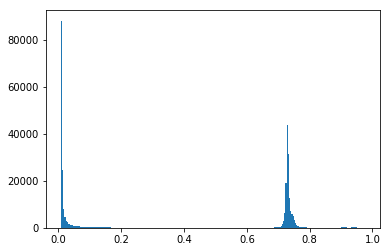

In [198]:
plt.figure()
plt.hist(img.ravel(), bins=256)
plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


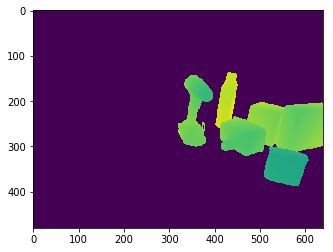

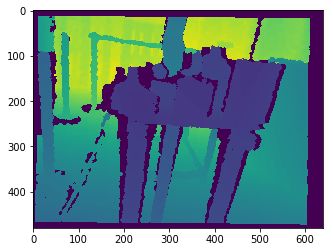

In [215]:
path = "/media/drc/DATA/chris_labelfusion/CORL2017/object_database/"
d_dir = os.listdir(path+"depth/")
gt_dir = os.listdir(path+"gtdepth/")
choice = np.random.randint(len(d_dir))
g= misc.imread(path+"gtdepth/"+gt_dir[choice])
d= misc.imread(path+"depth/"+d_dir[choice])
plt.imshow(g)
plt.figure()
plt.imshow(d)

In [142]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

NameError: name 'y_test' is not defined

In [26]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve

In [44]:
def test_on_set1(test,size=1000):
    def crop1(x,x1 = 200,x2 = 500,y1 = 200, y2 = 450):
        x = x[y1:y2,x1:x2]
        return x
    data = np.zeros((1,480,640,2))
    pred = []
    targ = []
    prob = []
    for i in test[:size]:
        r = normalize(misc.imread(i[0]))
        data[0,:,:,0] = r
        normal_img = grab_frame1(i[1],convert_rgb_normal)[:,:,2]
        d = crop1(hot_vectorize(misc.imread(i[2])))
        p = 1-normal_img
        p = crop1(p).flatten()
        prob.extend(p)
        pred.extend(list((np.round(p).astype(int))))
        targ.extend(list(d.flatten().astype(int)))
    return targ,prob

In [32]:
def test_on_set2(test,model,size=1000):
    data = np.zeros((1,480,640,1))
    pred = []
    targ = []
    prob = []
    for i in test[:size]:
        r = misc.imread(i[0])/3500.
        data[0,:,:,0] = r
        d = crop(hot_vectorize(misc.imread(i[2])))
        p = model.predict_on_batch(data)
        p = crop(p[0,:,:,0]).flatten()
        prob.extend(p)
        pred.extend(list((np.round(p).astype(int))))
        targ.extend(list(d.flatten().astype(int)))
    return targ,prob

In [29]:
from scipy import misc

In [30]:
def test_on_set(test,model,size=1000):
    data = np.zeros((1,480,640,2))
    pred = []
    targ = []
    prob = []
    for i in test[:size]:
        r = normalize(misc.imread(i[0]))
        data[0,:,:,0] = r
        normal_img = grab_frame1(i[1],convert_rgb_normal)[:,:,2]
        data[0,:,:,1] = normal_img
        d = crop(hot_vectorize(misc.imread(i[2])))
        p = model.predict_on_batch(data)
        p = crop(p[0,:,:,0]).flatten()
        prob.extend(p)
        pred.extend(list((np.round(p).astype(int))))
        targ.extend(list(d.flatten().astype(int)))
    return targ,prob


In [45]:
targ3,prob3 = test_on_set1(test,size=100)
roc3 = roc_curve(targ3,prob3)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]


In [40]:
targ1,prob1 = test_on_set2(test,model,size=100)
roc1 = roc_curve(targ1,prob1)

targ2,prob2 = test_on_set2(test,autoencoder,size=100)
roc2 = roc_curve(targ2,prob2)



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


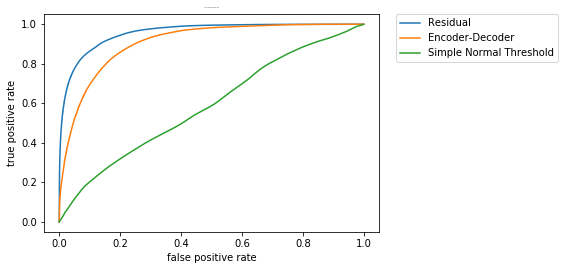

In [62]:
plt.figure()
plt.title("ROC curve for NDP prediction")

plt.plot(roc1[0],roc1[1],label= "Residual")
plt.plot(roc2[0],roc2[1],label= "Encoder-Decoder")
plt.plot(roc3[0],roc3[1],label= "Simple Normal Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.show()

In [ ]:
from pandas_ml import ConfusionMatrix
plt.figure()
c = ConfusionMatrix(targ,pred)
c.plot(normalized=True)
print (f1_score(targ,pred),roc)

In [81]:
test_on_set(test,autoencoder)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


AttributeError: 'numpy.ndarray' object has no attribute 'read'

In [55]:
%matplotlib inline
gt = g/3000.
pred = model.predict_on_batch(np.reshape(gt,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

NameError: name 'g' is not defined

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


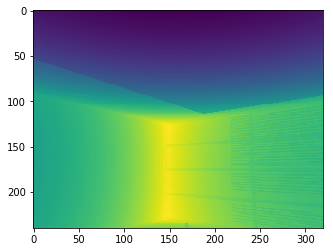

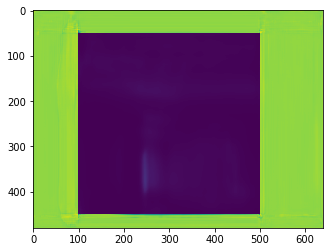

In [301]:
num = np.random.randint(999)
path  = "/media/drc/DATA/train/0/"+str(num)+"/depth/"
img_path = path+np.random.choice(os.listdir(path))
im = misc.imread(img_path)
%matplotlib inline
plt.figure()
plt.imshow(im)
plt.figure()
im = misc.imresize(im,(480,640))/255.
pred = autoencoder.predict_on_batch(np.reshape(im,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

In [83]:
test = train.next()
X_Test = test[0][0:1,:,:,0:1]

Y_Test = test[1][0:1]
imgs_mask_test = model.predict_on_batch(X_Test)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


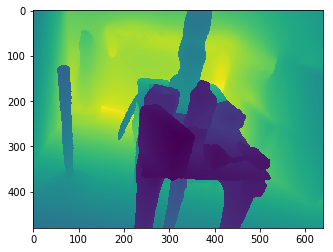

In [65]:
%matplotlib inline
img = X_Test[0][:,:,0]
plt.imshow(img)

In [86]:
i=np.reshape(img,(1,480,640,1))

In [89]:
%%timeit
a=model.predict_on_batch(i)

100 loops, best of 3: 13.4 ms per loop


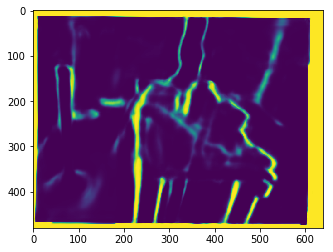

In [84]:
%matplotlib inline
tim
pred = model.predict_on_batch(np.reshape(img,(1,480,640,1)))
plt.imshow(np.reshape(pred,(480,640)))

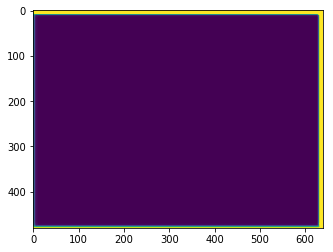

In [54]:
%matplotlib inline
img = np.reshape(imgs_mask_test[0],(480,640))
plt.imshow(img)

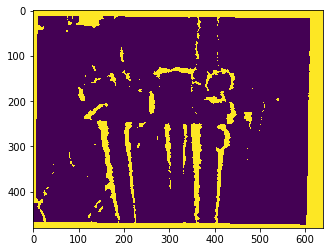

In [208]:
%matplotlib inline
img1 = np.reshape(Y_Test[0],(480,640))
plt.imshow(img1)

In [ ]:
img1 = np.copy(img)
img1[img1>.3] =1
plt.imshow(img1)